C:\ProgramData\Miniconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Miniconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\ProgramData\Miniconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)



--------- RUN NUMBER: 1 --------- 

Hyperparameters:
{
  "Run Number": 0,
  "Timesteps": 100,
  "N_u": 200,
  "N_f": 10000,
  "layers": [
    2,
    50,
    50,
    50,
    50,
    3
  ],
  "activation": "tanh",
  "initializer": "glorot_normal",
  "log_frequency": 10,
  "tf_epochs": 0,
  "tf_lr": 0.005,
  "tf_b1": 0.99,
  "tf_eps": 0.1,
  "use_scipy": true,
  "maxiter_scipy": 50,
  "maxfun_scipy": 100000,
  "maxcor_scipy": 50,
  "maxls_scipy": 50,
  "ftol_scipy": 2.220446049250313e-16,
  "weight_u": 1,
  "weight_PK": 1,
  "weight_Tamb": 1,
  "weight_f": 0.0001
}
TensorFlow version: 2.8.0
Eager execution: True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU-accerelated: False

Training started
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 2)                 0         
                                          

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


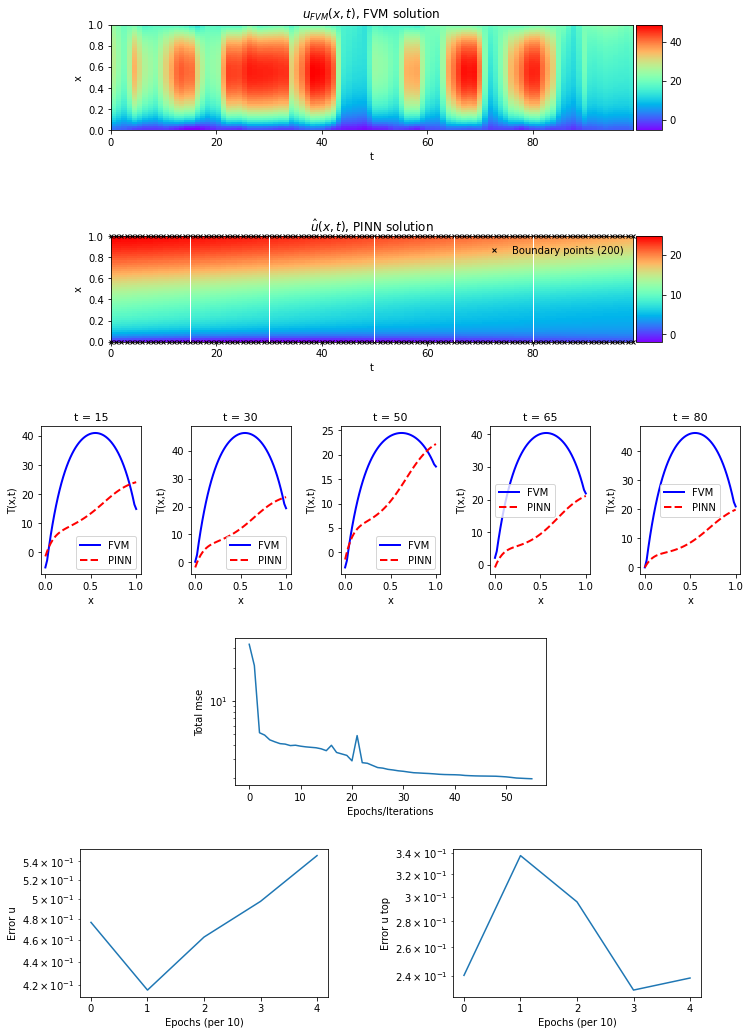

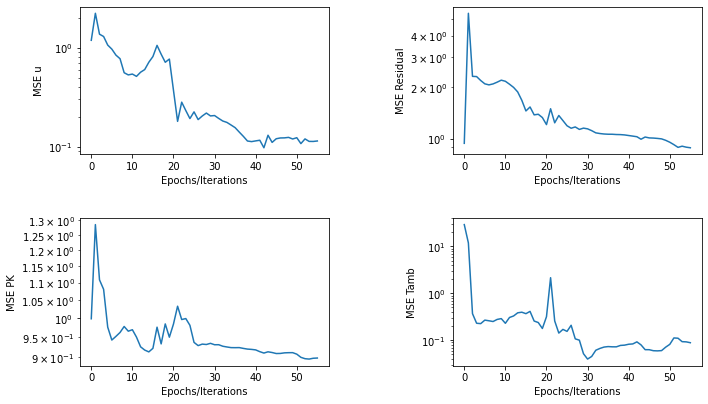

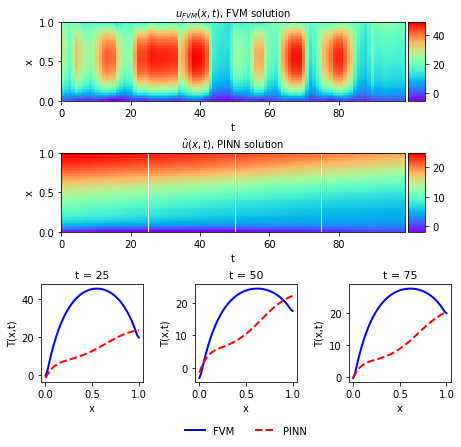


--------- RUN NUMBER: 2 --------- 

Hyperparameters:
{
  "Run Number": 1,
  "Timesteps": 100,
  "N_u": 200,
  "N_f": 10000,
  "layers": [
    2,
    50,
    50,
    50,
    50,
    3
  ],
  "activation": "tanh",
  "initializer": "glorot_normal",
  "log_frequency": 10,
  "tf_epochs": 0,
  "tf_lr": 0.005,
  "tf_b1": 0.99,
  "tf_eps": 0.1,
  "use_scipy": true,
  "maxiter_scipy": 50,
  "maxfun_scipy": 100000,
  "maxcor_scipy": 50,
  "maxls_scipy": 50,
  "ftol_scipy": 2.220446049250313e-16,
  "weight_u": 1,
  "weight_PK": 1,
  "weight_Tamb": 1,
  "weight_f": 0.0001,
  "GPU": "No"
}
TensorFlow version: 2.8.0
Eager execution: True
GPU-accerelated: False

Training started
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 2)                 0         
                                                                 
 dense_5 (Dense)             (None, 50) 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


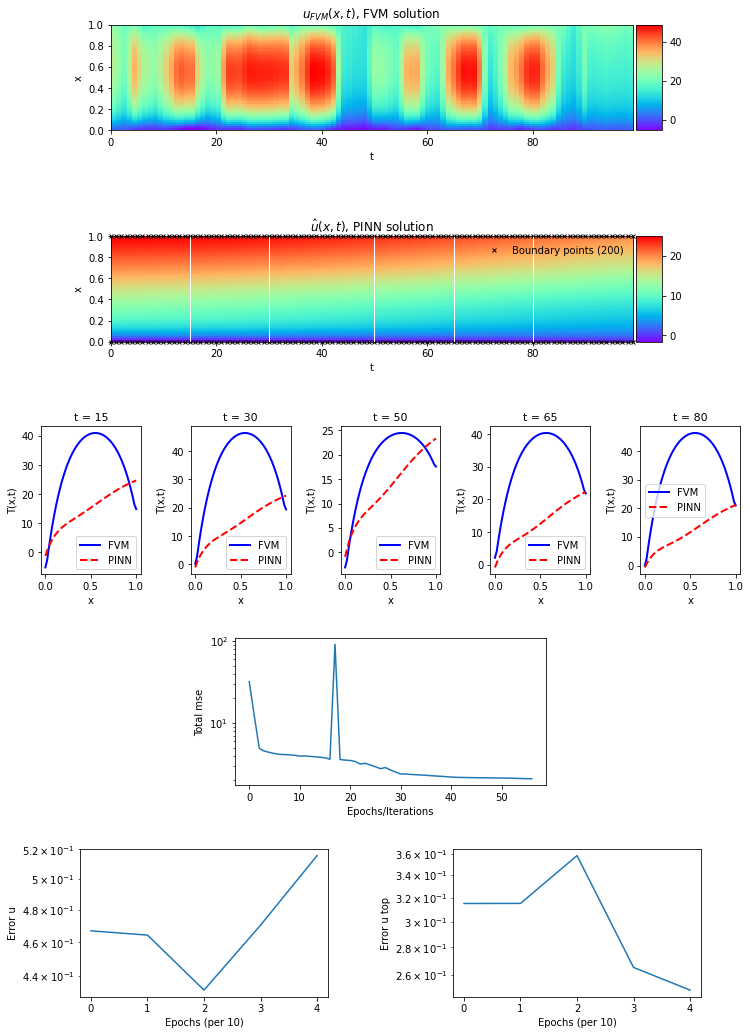

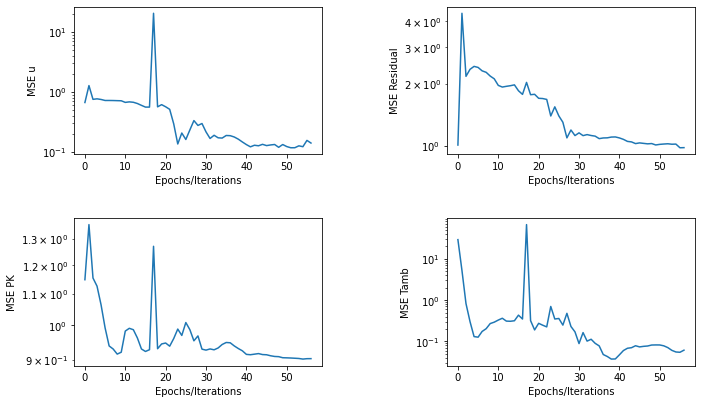

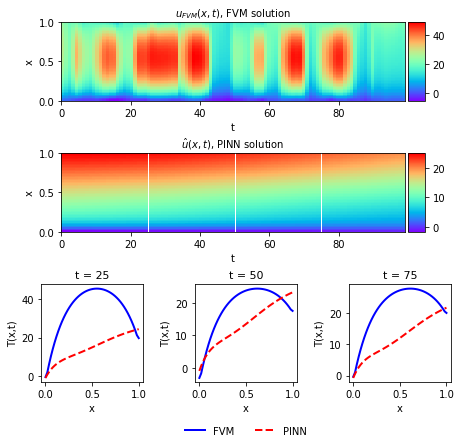


 Number of runs: 2


In [1]:
# PINN model with three outputs

# Code sources:
# https://github.com/maziarraissi/PINNs
# https://github.com/pierremtb/PINNs-TF2.0
# https://github.com/levimcclenny/SA-PINNs

# Imports
import sys
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from scipy import optimize
from sklearn.metrics import mean_squared_error
import xlsxwriter

# Imports from python scripts
from prepare_data import prepare_data
from numerical_solution import numerical_solution
from plot_function import plot_function
from plot_small import plot_small
from Logger import Logger
from pred_data_prep import pred_data_prep
from plot_collocation import plot_collocation
from simulate_data import simulate_data

# Set random seed
#np.random.seed(1234)
#tf.random.set_seed(1234)

# PATH TO SAVE RESULTS TO
save_path = "Results/"
# LOAD WEIGHTS
path_to_weights = ""
# SAVE WEIGHTS
weights_file = "PINN1_model"

# PINN
class PINN():
    def __init__(self, hp, logger, X_u, u, X_f, lb, ub, PK, Tamb, P0, k, h, rho, c, u_mean, PK_mean, Tamb_mean, u_std, PK_std, Tamb_std, pretrained_weights = None):

        self.dtype = "float64"
        self.hp = hp
        self.use_scipy = hp["use_scipy"]
        
        # Initialize Adam Optimizer
        self.tf_epochs = hp["tf_epochs"]
        self.tf_optimizer = tf.keras.optimizers.Adam(learning_rate = hp["tf_lr"], beta_1=hp["tf_b1"], epsilon=hp["tf_eps"])
        
        # Neural Network using Keras
        # --------------------
        layers = hp["layers"]
        tf.keras.backend.set_floatx(self.dtype)
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.InputLayer(input_shape=(layers[0],)))
        self.model.add(tf.keras.layers.Lambda(lambda X: 2.0*(X - lb)/(ub - lb) - 1.0))
        for width in layers[1:-1]:
            if hp["activation"] == "tanh":
                self.model.add(tf.keras.layers.Dense(width, activation=tf.nn.tanh, kernel_initializer=hp["initializer"]))
        self.model.add(tf.keras.layers.Dense(layers[-1], activation=None, kernel_initializer=hp["initializer"]))
        # --------------------

        # Load weights
        if pretrained_weights is not None:
            self.model.load_weights(pretrained_weights)
        
        # Storing sizes of weights & biases - for later
        self.sizes_w = []
        self.sizes_b = []
        for i, width in enumerate(layers):
            if i != 1:
                self.sizes_w.append(int(width * layers[1]))
                self.sizes_b.append(int(width if i != 0 else layers[1]))
        
        # Logger
        self.logger = logger
        
        # Collocation and Boundary Points
        self.X_u = self.tensor(X_u)
        self.x_u = self.tensor(X_u[:,0:1])
        self.t_u = self.tensor(X_u[:,1:2])
        self.x_f = self.tensor(X_f[:, 0:1])
        self.t_f = self.tensor(X_f[:, 1:2])
        
        self.lb = lb
        self.ub = ub
        
        # Parameters
        self.u = u
        self.PK = PK
        self.Tamb = Tamb
        self.layers = layers
        self.P0 = P0
        self.k = k
        self.h = h
        self.rho = rho
        self.c = c
        
        # Epoch counter
        self.epoch = 0

        # Normalization
        self.u_mean = u_mean
        self.PK_mean = PK_mean
        self.Tamb_mean = Tamb_mean
        self.u_std = u_std
        self.PK_std = PK_std
        self.Tamb_std = Tamb_std
        
    # NN
    def net_u_pk_tamb(self, X_u):
        u_pk_tamb = self.model(X_u)
        u = u_pk_tamb[:,0:1]
        PK = u_pk_tamb[:,1:2]
        Tamb = u_pk_tamb[:,2:3]
        return u, PK, Tamb

    # Residual
    def net_f(self):
        
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.x_f)
            with tf.GradientTape(persistent=True) as tape2:
                tape2.watch(self.x_f)
                tape2.watch(self.t_f)
                X_f = tf.concat([self.x_f, self.t_f], axis=1)
                
                # Prediction
                u, PK, Tamb = self.net_u_pk_tamb(X_f)

                # Denormalize prediction
                u = tf.multiply(u, self.u_std)
                u = tf.add(u, self.u_mean)
                PK = tf.multiply(PK, self.PK_std)
                PK = tf.add(PK, self.PK_mean)
                Tamb = tf.multiply(Tamb, self.Tamb_std)
                Tamb = tf.add(Tamb, self.Tamb_mean)
                
            u_x = tape2.gradient(u, self.x_f)
            u_t = tape2.gradient(u, self.t_f)
            
        u_xx = tape.gradient(u_x, self.x_f) 
        del tape
        #f = u_t -  self.k*u_xx/(self.rho*self.c) - (self.P0 + PK - self.h*(u - Tamb))/(self.rho*self.c)
        f = ((self.rho*self.c)/self.k)*u_t - u_xx - (self.P0 + PK - self.h*(u - Tamb))/self.k
        return f
    
    # Loss
    def loss(self, u_PK_Tamb, u_PK_Tamb_pred):
        
        u_pred, PK_pred, Tamb_pred = self.net_u_pk_tamb(self.X_u)
        f_pred = self.net_f()
        mse_u = tf.reduce_mean(tf.square(u_pred - self.u)) 
        mse_PK = tf.reduce_mean(tf.square(PK_pred - self.PK)) 
        mse_Tamb = tf.reduce_mean(tf.square(Tamb_pred - self.Tamb)) 
        mse_f = tf.reduce_mean(tf.square(f_pred))

        mse_u = tf.multiply(mse_u, hp["weight_u"])
        mse_Tamb = tf.multiply(mse_Tamb, hp["weight_Tamb"])
        mse_PK = tf.multiply(mse_PK, hp["weight_PK"])
        mse_f = tf.multiply(mse_f, hp["weight_f"])

        self.logger.append_losses(mse_u.numpy(), mse_PK.numpy(), mse_Tamb.numpy(), mse_f.numpy())
        self.epoch += 1
        if self.epoch % hp["log_frequency"] == 0:
            self.logger.log_train_progress(self.epoch)
            tf.print(f"mse_u {mse_u.numpy()}    mse_PK {mse_PK.numpy()}  mse_Tamb  {mse_Tamb.numpy()}   mse_f {mse_f.numpy()}")
            tf.print(f"Total mse: {mse_u + mse_PK + mse_Tamb + mse_f}" )
            print('----------------')
            
        return mse_u + mse_PK + mse_Tamb + mse_f
    
    # Predict
    def predict(self, X_star):
        pred = self.model(X_star)

        # Denormalize prediction
        u_pred = pred[:, 0:1]*self.u_std + self.u_mean
        PK_pred = pred[:, 1:2]*self.PK_std + self.PK_mean
        Tamb_pred = pred[:, 2:3]*self.Tamb_std + self.Tamb_mean

        return u_pred.numpy(), PK_pred.numpy(), Tamb_pred.numpy()

    # Training
    def fit(self):
        self.logger.log_train_start(self)

        # Creating the tensors
        X_u = self.tensor(self.X_u)
        u_PK_Tamb_train = tf.concat([self.u, self.PK, self.Tamb], axis=1)
        
        # Optimizing
        # Adam
        self.tf_optimization(X_u, u_PK_Tamb_train)
        # L-BFGS-B
        if self.use_scipy:
            self.solve_with_ScipyOptimizer(X_u, u_PK_Tamb_train)
        
        self.logger.log_train_end(self.epoch)
    
    # ADAM Optimization
    def tf_optimization(self, X_u, u):
        self.logger.log_train_opt("Adam")
        for epoch in range(self.tf_epochs):
            loss_value, grads = self.grad(X_u, u)
            self.tf_optimizer.apply_gradients(zip(grads, self.wrap_training_variables()))
    
    def grad(self, X, u):
        with tf.GradientTape(persistent=True) as tape:
            loss_value = self.loss(u, self.model(X))
        grads = tape.gradient(loss_value, self.wrap_training_variables())
        return loss_value, grads
        
    # LBFGS-B using Scipy Optimization (not available in TF + not GPU supported)
    def solve_with_ScipyOptimizer(self, X_u, u):
        self.logger.log_train_opt("LBFGS-B with scipy")
        loss_and_flat_grad = self.get_loss_and_flat_grad(X_u, u)
        return scipy.optimize.minimize(loss_and_flat_grad, x0=self.get_weights(),
                                       jac=True,
                                       method='L-BFGS-B', options = {'maxiter': hp["maxiter_scipy"], 
                                                                     'maxfun': hp["maxfun_scipy"],
                                                                     'maxcor': hp["maxcor_scipy"] ,
                                                                     'maxls': hp["maxls_scipy"],
                                                                     'ftol' : hp["ftol_scipy"],
                                                                     'iprint': 0})
    
    # Helpers for optimization:
    def wrap_training_variables(self):
        var = self.model.trainable_variables
        return var

    # L-BFGS weight getting and setting. From: https://github.com/pierremtb/PINNs-TF2.0
    def get_weights(self, convert_to_tensor=True):
        w = []
        for layer in self.model.layers[1:]:
            weights_biases = layer.get_weights()
            weights = weights_biases[0].flatten()
            biases = weights_biases[1]
            w.extend(weights)
            w.extend(biases)
        if convert_to_tensor:
            w = self.tensor(w)
        return w
    
    def set_weights(self, w):
        for i, layer in enumerate(self.model.layers[1:]):
            start_weights = sum(self.sizes_w[:i]) + sum(self.sizes_b[:i])
            end_weights = sum(self.sizes_w[:i+1]) + sum(self.sizes_b[:i])
            weights = w[start_weights:end_weights]
            w_div = int(self.sizes_w[i] / self.sizes_b[i])
            weights = tf.reshape(weights, [w_div, self.sizes_b[i]])
            biases = w[end_weights:end_weights + self.sizes_b[i]]
            weights_biases = [weights, biases]
            layer.set_weights(weights_biases)
    
    # Calculate gradient and get it in right shape
    def get_loss_and_flat_grad(self, X, u):
        def loss_and_flat_grad(w):
            with tf.GradientTape() as tape2:
                self.set_weights(w) 
                loss_value = self.loss(u, self.model(X))
            grad = tape2.gradient(loss_value, self.wrap_training_variables())
            grad_flat = []
            for g in grad:
                grad_flat.append(tf.reshape(g, [-1]))
            grad_flat = tf.concat(grad_flat, 0)
            return loss_value.numpy(), grad_flat.numpy() 
        return loss_and_flat_grad

    # General helpers:
    def summary(self):
        return self.model.summary()
    def tensor(self, X):
        return tf.convert_to_tensor(X, dtype=self.dtype)


def hyperparameter_loop(run_no, T_solution, N_u, N_f, layers, act_fcn, mse_wt, steps_t): 

    hp["N_u"] = N_u
    hp["N_f"] = N_f
    hp["layers"] = layers
    hp["activation"] = act_fcn
    hp["weight_u"] = mse_wt[0]
    hp["weight_PK"] = mse_wt[1]
    hp["weight_Tamb"] = mse_wt[2]
    hp["weight_f"] = mse_wt[3]
    
    T_tog = T_solution[0:steps_t, :]

    # Prepare data
    X_f_train, X_u_train, u_train, PK_train, Tamb_train, Ttop_train, lb, ub, X_star, u_star, PK_star, Tamb_star, Ttop_star, PK_tog, Tamb_tog, X, T, x, t, PK_f, Tamb_f, Ttop_f  = prepare_data(data_df, T_tog, hp["N_u"], hp["N_f"])

    # Normalize data and get normalization constants
    u_train_norm = (u_train - np.mean(u_train)) / np.std(u_train)
    PK_train_norm = (PK_train - np.mean(PK_train)) / np.std(PK_train)
    Tamb_train_norm = (Tamb_train - np.mean(Tamb_train)) / np.std(Tamb_train)
    u_mean = np.mean(u_train)
    PK_mean = np.mean(PK_train)
    Tamb_mean = np.mean(Tamb_train)
    u_std = np.std(u_train)
    PK_std = np.std(PK_train)
    Tamb_std = np.std(Tamb_train)

    # Create logger
    logger = Logger(hp)

    # Variables
    P0 = 15
    k = 0.05
    h = 1
    rho = 0.9
    c = 2

    # Initialize the model 
    pinn = PINN(hp, logger, X_u_train, u_train_norm, X_f_train, lb, ub, PK_train_norm, Tamb_train_norm, P0, k, h, rho, c, u_mean, PK_mean, Tamb_mean, u_std, PK_std, Tamb_std)
    #pinn = PINN(hp, logger, X_u_train, u_train_norm, X_f_train, lb, ub, PK_train_norm, Tamb_train_norm, P0, k, h, rho, c, u_mean, PK_mean, Tamb_mean, u_std, PK_std, Tamb_std, path_to_weights)

    # Error for top-oil temperature between FVM and PINN
    index = list(range(51, 52*steps_t ,52))
    u_star_ind = u_star[index]  

    # Defining the error function for the logger
    def error():
        u_pred, PK_pred, Tamb_pred = pinn.predict(X_star)
        u_pred_ind = u_pred[index]
        error_u = np.linalg.norm(u_pred - u_star, 2) / np.linalg.norm(u_star, 2)
        error_u_top = np.linalg.norm(u_star_ind-u_pred_ind,2)/np.linalg.norm(u_star_ind,2) 
        return [error_u, error_u_top]

    logger.set_error_fn(error)

    # Training the PINN
    pinn.fit()
    epochs = pinn.epoch
    time = pinn.logger.get_elapsed()

    mse_u_final, mse_PK_final, mse_Tamb_final, mse_f_final, mse_final = pinn.logger.get_final_losses_lists_4()
    mse_u, mse_PK, mse_Tamb, mse_f, mse, error_u_list, error_u_top_list = pinn.logger.get_losses_lists_4()

    # PREDICTIONS AND ERRORS
    u_pred, PK_pred, Tamb_pred = pinn.predict(X_star)

    # Error between FVM results and predictions by PINN
    error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)   
    print('Error u, L2: %e' % (error_u))
    error_u_RMSE = mean_squared_error(u_star, u_pred, squared=False)
    print('Error u, RMSE: %e' % (error_u_RMSE))

    # Error for top-oil temperature between FVM and PINN
    index = list(range(51,5200,52))
    u_star_ind = u_star[index]
    u_pred_ind = u_pred[index]
    error_u_top = np.linalg.norm(u_star_ind-u_pred_ind,2)/np.linalg.norm(u_star_ind,2)   
    print('Error u_top: %e' % (error_u_top))

    # Collect Other errors FVM and PINN
    U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
    PPKK_pred = griddata(X_star, PK_pred.flatten(), (X, T), method='cubic')
    TTamb_pred = griddata(X_star, Tamb_pred.flatten(), (X, T), method='cubic')
    Error_u = np.abs(T_tog - U_pred)
    Error_PK = np.abs(PK_tog - PPKK_pred)
    Error_Tamb = np.abs(Tamb_tog - TTamb_pred)

    # Plotting
    filename = "plot_" + str(run_no)
    filepath = save_path + filename
    time_list = [15,30,50,65,80]
    plot_function(filepath, x, t, T_tog, U_pred, X_u_train, u_train, mse, error_u_list, error_u_top_list, mse_u, mse_f, time_list, hp["log_frequency"], mse_PK, mse_Tamb)
    plot_small(filepath, x, t, T_tog, U_pred, [25, 50, 75])
    plt.show()

    # Save weights of PINN
    pinn.model.save_weights(save_path + weights_file + '_' + str(run_no) + '.h5')
    
    return [error_u, error_u_RMSE, error_u_top, epochs, time, mse_final, mse_u_final, mse_PK_final, mse_Tamb_final, mse_f_final]
    

# Load Data - time series Ta, To & K
data_df = simulate_data()

# Numerical Solution
T_solution = numerical_solution(data_df.iloc[0:500, :], 50, c=2)

# Hyperparameters 
hp = {}

# For storing run number later
hp["Run Number"] = 0

# Timesteps to include
hp["Timesteps"] = 100

# Collocation points on the boundaries
hp["N_u"] = 100
# Collocation points on the domain
hp["N_f"] = 10000
# Layers
hp["layers"] = [2, 50, 50, 50, 50, 3]
# Activation Function
hp["activation"] = "tanh"
# Initialization
hp["initializer"] = "glorot_normal"

# How often to Display Epochs
hp["log_frequency"] = 10

# Adam optimizer
hp["tf_epochs"] = 0
hp["tf_lr"] = 0.005
hp["tf_b1"] = 0.99
hp["tf_eps"] = 1e-1

# LBGFS-B optimizer
hp["use_scipy"] = True
hp["maxiter_scipy"] = 30000
hp["maxfun_scipy"] = 100000
hp["maxcor_scipy"] = 50
hp["maxls_scipy"] = 50
hp["ftol_scipy"] = 1.0 * np.finfo(float).eps

# Weight MSE terms
hp["weight_u"] = 1
hp["weight_PK"] = 1
hp["weight_Tamb"] = 1
hp["weight_f"] = 1

# Hyperparameter combinations to run
N_u = [200]
N_f = [10000]
layers = [[2, 50, 50, 50, 50, 3]]
plot_bool = True
activ_fcns = ["tanh"]
weights_mse = [[1, 1, 1, 1e-4]]
timesteps = [100]

# Start loop
run_number = 1
d_hp = {}
d_res = {}
random_seeds = 5

for ii in range(len(N_u)):
    for jj in range(len(N_f)):
        for kk in range(len(layers)):
            for ll in range(len(activ_fcns)):    
                for mm in range(len(weights_mse)):
                    for nn in range(len(timesteps)):
                        for oo in range(random_seeds):
                            print("\n--------- RUN NUMBER: "+ str(run_number) + " --------- \n")

                            results = hyperparameter_loop(run_number, T_solution, N_u[ii], N_f[jj], layers[kk], activ_fcns[ll], weights_mse[mm], timesteps[nn])

                            hp["Run Number"] = run_number
                            d_hp["dataframe_hp_"+str(run_number)] = pd.DataFrame()
                            if tf.test.is_gpu_available():
                                hp["GPU"] = "Yes"
                            else:
                                hp["GPU"] = "No"
                            d_hp["dataframe_hp_"+str(run_number)] = d_hp["dataframe_hp_"+str(run_number)].append(hp, ignore_index=True)

                            results_dict = {
                              "Run Number": run_number,
                              "error_u": results[0],
                              "error_u_RMSE": results[1],
                              "error_u_top": results[2],
                              "epochs": results[3],
                              "total time": results[4],
                              "Final mse" : results[5],
                              "mse_u" : results[6],
                              "mse_pk" : results[7],
                              "mse_Ta" : results[8],
                              "mse_f" : results[9]
                            }

                            d_res["dataframe_results_" + str(run_number)] = pd.DataFrame()
                            d_res["dataframe_results_" + str(run_number)] = d_res["dataframe_results_"+str(run_number)].append(results_dict, ignore_index=True)

                            run_number += 1

print("\n =========================== \n Number of runs: " + str(run_number - 1))

# Save results and hyperparameters to Excel
writer = pd.ExcelWriter(save_path + 'Results.xlsx', engine='xlsxwriter')   
workbook=writer.book
worksheet=workbook.add_worksheet('Res_hps')
writer.sheets['Res_hps'] = worksheet

for i, df_name in enumerate(d_res): 
    d_res[df_name].to_excel(writer, sheet_name='Res_hps', startrow=5*i, startcol=0)   
for x, df_name in enumerate(d_hp): 
    d_hp[df_name].to_excel(writer, sheet_name='Res_hps', startrow=5*x + 2, startcol=0)   

writer.save()